In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold


from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Re-import for demonstration
import matplotlib.pyplot as plt


# Model Training

In [18]:
# 1. Define feature types
numerical_features = ['login_count', 'days_since_last_login', 'support_tickets']
categorical_features = ['subscription_tier', 'region']

# 2. Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Create the full pipeline (Preprocessing + Model)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Mock Data Simulation
# Creating synthetic data for demonstration purposes
N_samples = 1000
X = pd.DataFrame({
    'login_count': np.random.normal(50, 10, N_samples),
    'days_since_last_login': np.random.randint(1, 90, N_samples),
    'support_tickets': np.random.randint(0, 5, N_samples),
    'subscription_tier': np.random.choice(['Basic', 'Premium'], N_samples),
    'region': np.random.choice(['North', 'South'], N_samples)
})
# Simulate an imbalanced target variable (10% churn)
y = np.random.choice([0, 1], N_samples, p=[0.9, 0.1])

# 4. Train the model (Assuming X and y are defined)
# model_pipeline.fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_pipeline.fit(X_train, y_train)
# ----------------------------------------------------

# 1. Predict probabilities (required for ROC AUC)
# We need the probability of the positive class (Churn=1)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# 2. Predict classes: 0 or 1 (required for Precision/Recall/F1)
y_pred = model_pipeline.predict(X_test)

# Cross Validation

In [25]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation using multiple scoring metrics (ROC AUC, Precision, Recall)
cv_results = cross_validate(
    model_pipeline,
    X_train, # Use the training features
    y_train, # Use the training target
    scoring=['roc_auc', 'precision', 'recall'], # Use multiple metrics
    cv=cv_strategy,
    n_jobs=-1, # Use all available cores
    return_train_score=False # Only need test scores
)

print("--- Cross-Validation Results (5 Folds) ---")
# Print ROC AUC results
roc_auc_scores = cv_results['test_roc_auc']
print(f"Mean CV ROC AUC: {np.mean(roc_auc_scores):.4f} (Std: {np.std(roc_auc_scores):.4f})")

# Print Precision/Recall results
precision_scores = cv_results['test_precision']
recall_scores = cv_results['test_recall']
print(f"Mean CV Precision: {np.mean(precision_scores):.4f} (Std: {np.std(precision_scores):.4f})")
print(f"Mean CV Recall: {np.mean(recall_scores):.4f} (Std: {np.std(recall_scores):.4f})")

# Interpretation: If the mean score is high and the standard deviation is low (e.g., < 0.02),
# the model's performance is stable and reliable across different subsets of the training data.

--- Cross-Validation Results (5 Folds) ---
Mean CV ROC AUC: 0.4741 (Std: 0.0482)
Mean CV Precision: 0.0000 (Std: 0.0000)
Mean CV Recall: 0.0000 (Std: 0.0000)


# Model Evaluation

In [6]:
# --- Metric 1: ROC AUC Score ---
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}\n")

# --- Metric 2: Precision, Recall, F1-Score ---
print("Classification Report (Precision/Recall/F1):\n")
# The report provides metrics for both classes (0 and 1)
print(classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)']))

# --- Metric 3: Feature Importance ---
# Access the trained Random Forest model within the pipeline
rf_model = model_pipeline.named_steps['classifier']

# Get the names of the final features after OneHotEncoding
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:\n")
print(importance_df.head(10))

ROC AUC Score: 0.5403

Classification Report (Precision/Recall/F1):

              precision    recall  f1-score   support

No Churn (0)       0.91      0.99      0.95       272
   Churn (1)       0.00      0.00      0.00        28

    accuracy                           0.90       300
   macro avg       0.45      0.50      0.47       300
weighted avg       0.82      0.90      0.86       300


Top 10 Feature Importances:

                          Feature  Importance
0                num__login_count    0.457426
1      num__days_since_last_login    0.383460
2            num__support_tickets    0.106301
4  cat__subscription_tier_Premium    0.013733
5               cat__region_North    0.013645
6               cat__region_South    0.012864
3    cat__subscription_tier_Basic    0.012571


# Visualization


--- Plot 1: ROC Curve ---


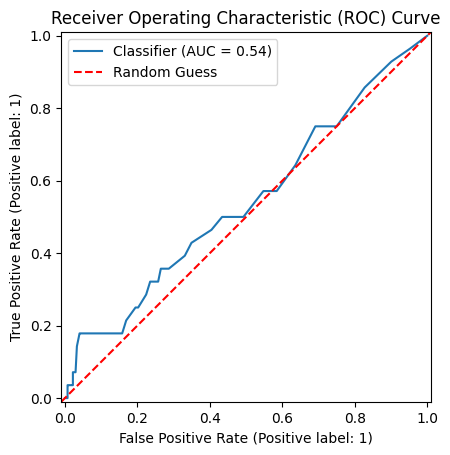

In [13]:
# --- Visualization 1: ROC Curve ---
print("\n--- Plot 1: ROC Curve ---")
# The ROC Curve visually assesses the model's ability to discriminate between classes
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.axline((0, 0), (1, 1), color='red', linestyle='--', label='Random Guess') # Add diagonal line for comparison
plt.legend()
plt.show()


--- Plot 2: Feature Importance Plot ---


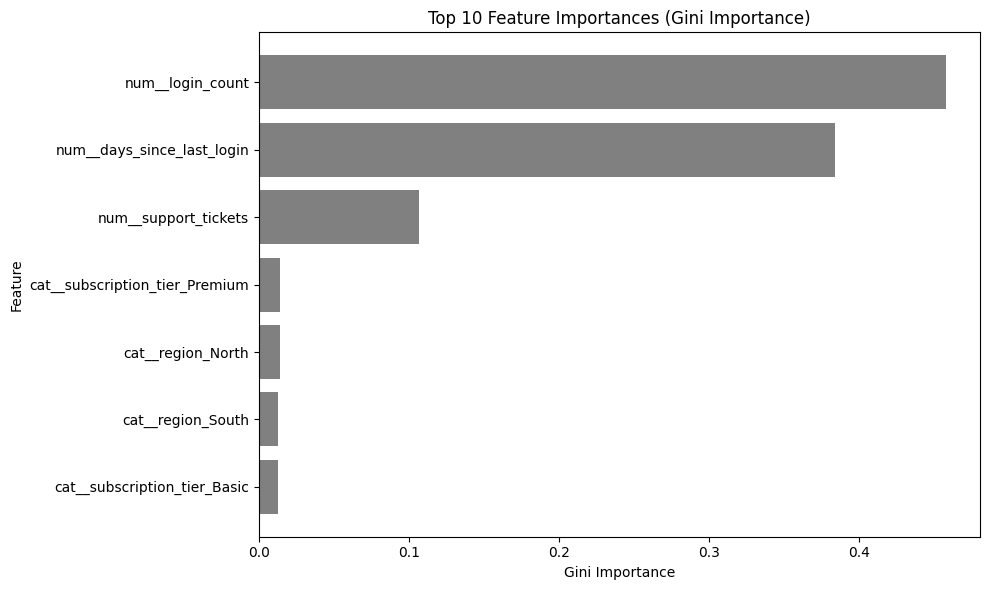

In [15]:
# --- Visualization 2: Feature Importance Plot ---
print("\n--- Plot 2: Feature Importance Plot ---")
# Bar plot to show the relative contribution of each feature using Matplotlib
plt.figure(figsize=(10, 6))
top_10 = importance_df.head(10)
# Use plt.barh for a horizontal bar plot
plt.barh(top_10['Feature'], top_10['Importance'], color='grey')
plt.gca().invert_yaxis() # Invert y-axis to display highest importance at the top
plt.title('Top 10 Feature Importances (Gini Importance)')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


--- Visualization: Precision & Recall Distribution Across CV Folds ---


/tmp/ipython-input-2653971809.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_data, labels=labels, patch_artist=True)


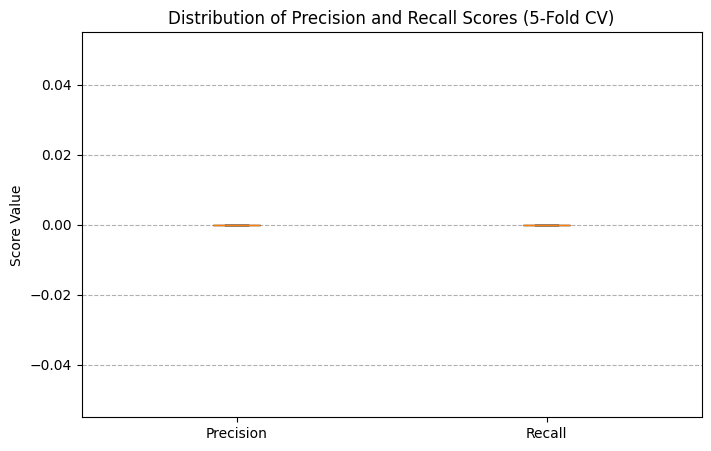

In [26]:
# --- Visualization 3: Precision and Recall Distribution ---
print("\n--- Visualization: Precision & Recall Distribution Across CV Folds ---")
cv_data = [precision_scores, recall_scores]
labels = ['Precision', 'Recall']

plt.figure(figsize=(8, 5))
# Generate a box plot to show the score distribution
plt.boxplot(cv_data, labels=labels, patch_artist=True)
plt.title('Distribution of Precision and Recall Scores (5-Fold CV)')
plt.ylabel('Score Value')
plt.grid(axis='y', linestyle='--')
plt.show()

# Interpretation: Box plots show the stability. If the box (IQR) is small, the score is stable.
# This visualization helps assess the trade-off inherent in the model (e.g., high precision often means lower recall).
# close to 0 precision and recall